In [18]:
c_g = torch.load("../data/control_variates/control_variates_global_r22.pt")
c_l = torch.load("../data/control_variates/control_variates_c0_r22.pt")

In [1]:
import torch
import os.path
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.utils.data import Subset, random_split, DataLoader, Dataset, BatchSampler, RandomSampler
from torchvision import transforms
from torchvision.transforms import functional as F
import sys
import colorsys

In [2]:
def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

# Statistics

In [2]:
export_path = "/local/scratch/motterbe/save_runs/2023_07_31_1846"
global_epochs = 300

In [3]:
def load_if_exists(path):
    total_path = f"{export_path}/{path}"
    if os.path.exists(total_path):
        return torch.load(total_path, map_location="cpu")
    else:
        return None


variates = [[load_if_exists(f"control_variates_c{client}_r{round}.pt") for client in range(0,10)] for round in range(0,global_epochs)]
c_g = [load_if_exists(f"control_variates/control_variates_global_r{round}.pt")  for round in range(0,global_epochs)]

In [5]:
stats = load_pickle(f"{export_path}/stats.pkl")

loss_before = np.asarray([[client["loss_before"] for client in round_] for round_ in stats])
loss_after = np.asarray([[client["loss_after"] for client in round_] for round_ in stats])
acc_before = np.asarray([[client["correct"]/client["size"] for client in round_] for round_ in stats])
acc_after = np.asarray([[client["correct_after"]/client["size"] for client in round_] for round_ in stats])
index_array = np.arange(0, global_epochs, 1)

In [91]:
indexed_loss_before = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index,client in enumerate(loss_before.T)])
indexed_loss_after = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index,client in enumerate(loss_after.T)])
indexed_acc_before = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index,client in enumerate(acc_before.T)])
indexed_acc_after = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index,client in enumerate(acc_after.T)])

In [3]:
def plot_stat_by_epoch(stat, ax=None, line=None, counterstat = None, countername="Control Variate", stat_max_x = None, counter_max_y = None):
    if ax is None or line is None:
        line, ax = plt.subplots()
    
    ax.set(xlabel="Epoch", ylabel="Accuracy")
    if stat_max_x is not None:
        ax.set_ylim((0,stat_max_x))
    for client_id, client_stats in enumerate(stat):
        ax.plot(client_stats[0], client_stats[1], label=f"Client {client_id}")

    ax2 = ax.twinx()
    ax2.set(ylabel="Local Control Variate")

    ax2.invert_yaxis()
    if counter_max_y is not None:
        ax2.set_ylim((counter_max_y,0))
    if counterstat is not None:
        for client_id, client_stats in enumerate(counterstat):
            ax2.plot(client_stats[0], client_stats[1], label=f"{countername} {client_id}", color="r")
    # plt.legend(loc="upper left")

def plot_multiple_stats_by_epoch(stats, counterstats):
    plot_count = len(stats)
    left_count = math.ceil(plot_count/2)
    # right_count = math.floor(plot_count/2)

    (lines, axes) = plt.subplots(left_count, 2, figsize=(20,10))

    stat_max = stats[:, 1].max()
    counter_max= counterstats[:, 1].max()

    for plot_index in range(0, plot_count):
        col = plot_index%2
        row = math.floor(plot_index/2)
        

        plot_stat_by_epoch(stat=[stats[plot_index]], counterstat=[counterstats[plot_index]], ax=axes[row, col], line=lines, countername="Control Variate", counter_max_y=counter_max, stat_max_x=1)
        axes[row, col].set_title(f"Client {plot_index}")
    
    for ax in axes.flat:
        ax.label_outer()
    
    plt.show()
        

In [90]:
def trySum(a, b):
    if a is None or b is None:
        return None
    else:
        return ((a-b)**2).sum()

def tryMean(a,b):
    if a is None or b is None:
        return None
    else:
        comp = torch.stack([((global_layer-local_layer)**2).sum().sqrt() for (global_layer,local_layer) in zip(a, b)]).mean()
        return comp

inter_difs = [{f"{index1}_{index2}": tryMean(v1,v2) for (index2, v2) in enumerate(round_variates) for (index1, v1) in enumerate(round_variates) if index1 > index2}  for round_variates in variates]
diffs = [[tryMean(g, c_l) for c_l in c_ls] for (g, c_ls) in zip(c_g, variates)]
offset_diffs = [[tryMean(c_g[i], c_l) for c_l in variates[i+1]] for i in range(0,global_epochs-1)]

indexed_cv_global_diff = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index, client in enumerate(np.asarray(diffs).T)])

In [14]:
inter_dif_per_round = [torch.stack([clientDif for (diffName, clientDif) in round.items() if clientDif is not None]).mean().item() for round in inter_difs]


diffPerRound = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).mean().item() for dif in diffs]
max_dif = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).max().item() for dif in diffs]
offset_diff_mean = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).mean().item() for dif in offset_diffs]
offset_max_dif = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).max().item() for dif in offset_diffs]

In [95]:
indexed_acc_before[:,1].max()

0.9896428571428572

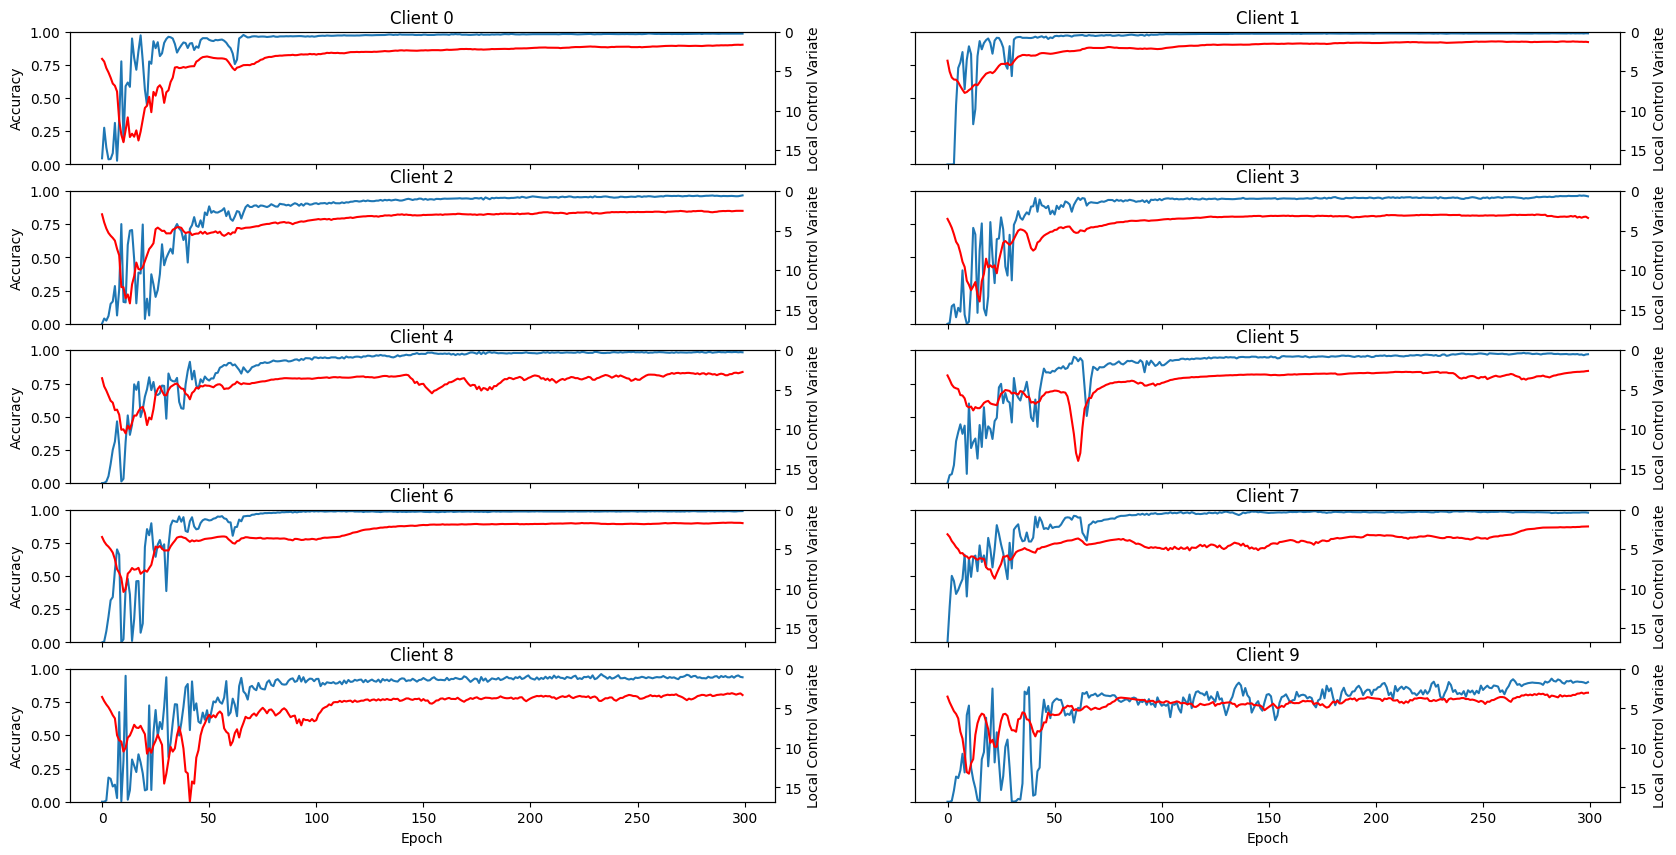

In [113]:
plot_multiple_stats_by_epoch(indexed_acc_before, indexed_cv_global_diff)

# Augmentations

In [3]:
# del sys.modules["utils.dataset.MNISTDataset"]
# del sys.modules["utils.dataset"]
# del sys.modules["utils"]
sys.path.append("../data")
# del colorcycle, CyclicDeform
# from utils.augmentations import colorcycle, CyclicDeform

In [4]:
from utils.dataset import CIFARDataset, MNISTDataset
from utils.augmentations.MultiConcatDataset import MultiConcatDataset
from utils.CudaDataset import CudaDataset

pickle_path = "../data/emnist/pickles/0.pkl"
t = load_pickle(pickle_path)

In [5]:
class AugSet(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

import bisect
import warnings
import torch
from typing import (
    Iterable,
    List,
    TypeVar,
)

T_co = TypeVar('T_co', covariant=True)

from torch.utils.data import Dataset, IterableDataset


import bisect
import warnings
from typing import (
    Iterable,
    List,
    TypeVar,
)

T_co = TypeVar('T_co', covariant=True)

from torch.utils.data import Dataset, IterableDataset


class DultiConcatDataset(Dataset[T_co]):
    r"""Dataset as a concatenation of multiple datasets.

    This class is useful to assemble different existing datasets.

    Args:
        datasets (sequence): List of datasets to be concatenated
    """
    datasets: List[Dataset[T_co]]
    cumulative_sizes: List[int]

    @staticmethod
    def cumsum(sequence):
        r, s = [], 0
        for e in sequence:
            l = len(e)
            r.append(l + s)
            s += l
        return r

    def __init__(self, datasets: Iterable[Dataset], device: torch.cuda.Device) -> None:
        super().__init__()
        self.device = device
        self.datasets = list(datasets)
        assert len(self.datasets) > 0, 'datasets should not be an empty iterable'  # type: ignore[arg-type]
        for d in self.datasets:
            assert not isinstance(d, IterableDataset), "ConcatDataset does not support IterableDataset"
        self.cumulative_sizes = self.cumsum(self.datasets)
        self.t_cumulative_sizes = torch.as_tensor(self.cumulative_sizes).to(device)

    def __len__(self):
        return self.cumulative_sizes[-1]

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            start = idx.start
            stop = idx.stop
            step = idx.step
            if start is None:
                start = 0
            if stop is None:
                stop = self.__len__()
            if step is None:
                step = 1

            idx = range(start, stop, step)

        t_idx = torch.as_tensor(idx).to(self.device)
        dataset_idx = torch.searchsorted(self.t_cumulative_sizes, t_idx, side="right")
        sample_idx = t_idx.clone()
        sample_idx[dataset_idx != 0] = t_idx[dataset_idx != 0] - self.t_cumulative_sizes[dataset_idx[dataset_idx != 0] -1]
        d2_indices = torch.stack((dataset_idx, sample_idx, t_idx, torch.arange(0, len(idx)).to(self.device)))

        mapped_sample_indices = []
        targets = []
        inputs = []
        # print(f"Retrieving samples from datasets with ids {torch.unique(dataset_idx)}")
        for dataset_id in torch.unique(dataset_idx):
            dataset_samples = d2_indices[0]==dataset_id
            sample_indices = d2_indices[:,dataset_samples][1]

            selected_data = self.datasets[dataset_id][sample_indices.tolist()]
            selected_ids = d2_indices[:,dataset_samples]

            mapped_sample_indices.append(selected_ids)      
            inputs.append(selected_data[0])
            targets.append(selected_data[1])

        tensor_targets = torch.concat(targets, dim=0)
        tensor_inputs = torch.concat(inputs, dim=0)
        tensor_indices_mapping = torch.concat(mapped_sample_indices, dim=1)
        test_index = tensor_indices_mapping[3].argsort()
        sorting_index = test_index
        sorted_indices = tensor_indices_mapping[:,sorting_index]

        tensor_targets = tensor_targets[sorting_index]
        tensor_inputs = tensor_inputs[sorting_index]

        return (tensor_inputs, tensor_targets)

    @property
    def cummulative_sizes(self):
        warnings.warn("cummulative_sizes attribute is renamed to "
                      "cumulative_sizes", DeprecationWarning, stacklevel=2)
        return self.cumulative_sizes


In [6]:
import colorsys
import math
import torch

class CycleColor:
    def __init__(self, epoch: int, cycle: int, tolerance: int, device: torch.device):
        self.epoch = epoch
        self.background_hue = ((self.epoch+10)*360/cycle)%360
        self.digit_hue = ((self.epoch+30)*360/cycle)%360
        self.tolerance = tolerance
        self.rgb_background = torch.tensor(colorsys.hsv_to_rgb(math.radians(self.background_hue), 0.5, 0.5)).to(device)
        self.rgb_digit = torch.tensor(colorsys.hsv_to_rgb(math.radians(self.digit_hue), 0.5, 0.5)).to(device)
        # print(self.rgb_digit)
    def __call__(self, sample: torch.tensor):
        max = torch.max(sample)
        min = torch.min(sample)
        image = (sample-min)/(max-min)

        background_mask = (image < image.min()+self.tolerance) & (image > image.min()-self.tolerance)
        digit_mask = ~background_mask
        color_pic = image.repeat_interleave(3, dim=1)
        permuted_color_pic = color_pic.permute((0,2,3,1))
        permuted_color_pic[background_mask.squeeze()]  = self.rgb_background
        permuted_color_pic[digit_mask.squeeze()]  = self.rgb_digit
        

        return color_pic


In [7]:
import numpy as np
import colorsys
import torch
import math
from torchvision.transforms.functional import elastic_transform
import torch.nn.functional as Fun

class CyclicTorchDeform:
    def __init__(self, epoch: int, cycle: int, img_size: tuple[int], device: torch.device, control_points: tuple[int], stretch_intensity=0.35):
        self.epoch = epoch
        assert isinstance(epoch, int)
        assert isinstance(cycle, int)
        assert isinstance(img_size, tuple)
        angle = (epoch*360/cycle)%360

        x = torch.zeros(size=control_points)
        y = torch.zeros(size=control_points)

        for row in range(control_points[0]):
            for col in range(control_points[1]):
                x[col,row] = math.sin(math.radians(angle))
                y[col,row] = math.cos(math.radians(angle))
                angle += 45

        displacement_grid = np.mgrid[-1:1:img_size[0]*1j, -1:1:img_size[1]*1j]
        old_x = x[0,0].numpy()
        old_y = y[0,0].numpy()
        x = x.unsqueeze(0).unsqueeze(0)
        y = y.unsqueeze(0).unsqueeze(0)

        x_displacement = Fun.interpolate(torch.as_tensor(x), img_size, mode="bicubic", align_corners=False)
        y_displacement = Fun.interpolate(torch.as_tensor(y), img_size, mode="bicubic", align_corners=False)

        # displacement_weights = np.abs(old_x*-displacement_grid[0]-(-displacement_grid[1])*(old_y))/np.linalg.norm((old_x,old_y))
        # displacement_weights -= 1
        # displacement_weights = np.abs(displacement_weights)
        # displacement_weights /= displacement_weights.max()
        # displacement_weights = np.around(displacement_weights, 2)
        # # z_displacement = np.full((control_points[0],control_points[1]), 1)
        # old_displacement = torch.from_numpy(np.asarray((old_x*displacement_weights, old_y*displacement_weights))* stretch_intensity)

        # print(x_displacement.shape)
        displacement = torch.concat((x_displacement, y_displacement), axis=1)* stretch_intensity
        # print(displacement.shape)
        self.displacement = torch.unsqueeze(displacement[0].permute((1,2,0)), 0).to(device)

    def __call__(self, sample: torch.tensor):
        deformed = elastic_transform(sample, self.displacement)
        return deformed


In [14]:
device = "cuda:0"
train_data = [CudaDataset(_set["train"], device=device) for _set in t[1:]]

cycle_length = 10
mean=0
std=0
nb_samples=0

for cycle in range(0,cycle_length):
    data_transforms = transforms.Compose([
        CyclicTorchDeform(epoch=cycle, cycle=cycle_length, img_size=(28,28), stretch_intensity=0.2, device=device, control_points=(2,2)),
        # transforms.Normalize(mean= 0, std=1),
        CycleColor(epoch =cycle, cycle=cycle_length, tolerance=0.1, device=device),
        transforms.Normalize(mean=(0.3798, 0.3760, 0.3695) , std=(0.0461, 0.0469, 0.0455))
        # transforms.ToTensor()
    ])
    aug_set = AugSet(DultiConcatDataset(train_data, device), data_transforms)
    data,targets = aug_set[:]
    size = data.size(0)
    view = data.view(size, data.size(1), -1)
    current_mean = view.mean(2).sum(0)
    mean += current_mean
    current_std = view.std(2).sum(0)
    std += current_std
    print(view.std(2).shape, current_std, current_std/size, current_mean/size)
    nb_samples += size
    del aug_set, view, targets, data
    torch.cuda.empty_cache()

torch.Size([201600, 3]) tensor([0., 0., 0.], device='cuda:0') tensor([0., 0., 0.], device='cuda:0') tensor([ 2.6074, -2.6866, -2.6264], device='cuda:0')
torch.Size([201600, 3]) tensor([0., 0., 0.], device='cuda:0') tensor([0., 0., 0.], device='cuda:0') tensor([-2.8156, -1.4601,  2.8681], device='cuda:0')
torch.Size([201600, 3]) tensor([0., 0., 0.], device='cuda:0') tensor([0., 0., 0.], device='cuda:0') tensor([-0.3201,  2.6439, -2.6264], device='cuda:0')
torch.Size([201600, 3]) tensor([0., 0., 0.], device='cuda:0') tensor([0., 0., 0.], device='cuda:0') tensor([ 2.6074, -2.6866,  1.1663], device='cuda:0')
torch.Size([201600, 3]) tensor([0., 0., 0.], device='cuda:0') tensor([0., 0., 0.], device='cuda:0') tensor([-2.8156,  2.2194,  2.8681], device='cuda:0')
torch.Size([201600, 3]) tensor([0., 0., 0.], device='cuda:0') tensor([0., 0., 0.], device='cuda:0') tensor([ 2.6074,  1.8420, -2.6264], device='cuda:0')
torch.Size([201600, 3]) tensor([0., 0., 0.], device='cuda:0') tensor([0., 0., 0.],

In [ ]:
device = "cuda:0"

data_transforms = transforms.Compose([
    CyclicTorchDeform(epoch= 19, cycle= 120, img_size=(28,28), stretch_intensity=0.2, device=device, control_points=(2,2)),
    CycleColor(epoch = 25, cycle= 80, tolerance=0.1, device=device),
    transforms.Normalize(mean=(0.3798, 0.3760, 0.3695) , std=(0.0461, 0.0469, 0.0455)),
])

train_data = [CudaDataset(_set["train"], device=device) for _set in t[1:]]
print(len(train_data))
aug_set = AugSet(DultiConcatDataset(train_data, device=device), data_transforms)
samp = BatchSampler(RandomSampler(aug_set), 5000, drop_last=False)
# aug_loader =  DataLoader(au

fig, axs = plt.subplots(1,20, figsize=(30,10))

print(len(aug_set))
for batch_num, idx in enumerate(samp):
    xs,ys=aug_set[idx]
    # print(xs.shape)
    x=xs[5]
    pic = x.to("cpu").permute(1, 2, 0).numpy()
    normalized = (pic - np.min(pic))/np.ptp(pic)

    axs[batch_num].imshow(normalized, cmap="gray")

# plt.imshow(x.transpose(1,2,0))
    

In [261]:
tensor_pic = t[0]["train"][0][3]
numpy_pic = tensor_pic.permute(1, 2, 0).numpy()

IndexError: tuple index out of range

In [235]:
def color_and_normalize(pic, background_hue, digit_hue, intensity_tolerance):
    background_mask = (pic < pic.min()+intensity_tolerance) & (pic > pic.min()-intensity_tolerance)
    digit_mask = ~background_mask#(pic < pic.max()+range) & (pic > pic.max()-range)
    normalized = (pic - np.min(pic))/np.ptp(pic)
    color_pic = np.concatenate((normalized,)*3, axis=2)

    color_pic[background_mask.squeeze(), :]  = colorsys.hsv_to_rgb(math.radians(background_hue), 0.5, 0.5)
    color_pic[digit_mask.squeeze(), :]  = colorsys.hsv_to_rgb(math.radians(digit_hue), 0.5, 0.5)
    return color_pic

def cyclic_deform(sample, epoch, cycle, control_points, img_size, axs=None, axs_index=None):
    device="cpu"
    stretch_intensity = 0.35
    angle = (epoch*360/cycle)%360
    angle = (epoch*360/cycle)%360

    x = torch.zeros(size=control_points)
    y = torch.zeros(size=control_points)


    for row in range(control_points[0]):
        for col in range(control_points[1]):
            x[col,row] = math.sin(math.radians(angle))
            y[col,row] = math.cos(math.radians(angle))
            angle += 45

    # print(x)

    displacement_grid = np.mgrid[-1:1:img_size[0]*1j, -1:1:img_size[1]*1j]
    old_x = x[0,0].numpy()
    old_y = y[0,0].numpy()
    x = x.unsqueeze(0).unsqueeze(0)
    y = y.unsqueeze(0).unsqueeze(0)
    # print(x)


    x_displacement = Fun.interpolate(torch.as_tensor(x), img_size, mode="bicubic", align_corners=False)
    y_displacement = Fun.interpolate(torch.as_tensor(y), img_size, mode="bicubic", align_corners=False)
    # y_displacement = Fun.interpolate(, img_size, mode="bicubic", align_corners=False)



    displacement_weights = np.abs(old_x*-displacement_grid[0]-(-displacement_grid[1])*(old_y))/np.linalg.norm((old_x,old_y))
    displacement_weights -= 1
    displacement_weights = np.abs(displacement_weights)
    displacement_weights /= displacement_weights.max()
    displacement_weights = np.around(displacement_weights, 2)
    # z_displacement = np.full((control_points[0],control_points[1]), 1)
    old_displacement = torch.from_numpy(np.asarray((old_x*displacement_weights, old_y*displacement_weights))* stretch_intensity)

    # print(x_displacement.shape)
    displacement = torch.concat((x_displacement, y_displacement), axis=1)* stretch_intensity
    # print(displacement.shape)
    displacement = torch.unsqueeze(displacement[0].permute((1,2,0)), 0).to(device)
    # displacement = torch.unsqueeze(displacement.permute((1,2,0)), 0)



    deformed = F.elastic_transform(sample, displacement, )

    if(axs is not None and axs_index is not None):
        if(axs[0, axs_index] is not None):
            ax = axs[0, axs_index]
          
                    # ax.axline((x_center,y_center), (x_center+x[0,0,row,col],y_center+y[0,0,row,col]), color="white", x_max=x_center+7, y_max=y_center+7)

            base_indices = np.arange(0, 28, 1)
            l1 = np.stack((base_indices, np.full((28), 7)))
            deformed_l1 = l1-displacement[0,l1[0],l1[1]].numpy().T*14
            l2 = np.stack((base_indices, np.full((28), 21)))
            deformed_l2 = l2-displacement[0,l2[0],l2[1]].numpy().T*14
            
            l3 = np.stack((np.full((28), 7), base_indices))
            deformed_l3 = l3-displacement[0,l3[0],l3[1]].numpy().T*14
            l4 = np.stack((np.full((28), 21), base_indices))
            deformed_l4 = l4-displacement[0,l3[0],l3[1]].numpy().T*14


            ax.plot(l1[0], deformed_l1[1], color="white")
            ax.plot(l2[0], deformed_l2[1], color="white")
            ax.plot(deformed_l3[0], l3[1], color="white")
            ax.plot(deformed_l4[0], l4[1], color="white")

        if(axs[1, axs_index] is not None):
            ax = axs[1, axs_index]
            for row in range(control_points[0]):
                for col in range(control_points[1]):
                    center_indices = np.linspace(-7,7,14)
                    y_values = center_indices * y[0,0,col,row].numpy()
                    y_values += 7+14*(col)
                    x_values = center_indices * x[0,0,col,row].numpy() + 7+14*(row)
                    ax.plot(x_values, y_values, color="white")
            ax.imshow(deformed.permute((1,2,0)).numpy(), cmap="gray")

        if(axs[2, axs_index] is not None):
            ax = axs[2, axs_index]
            ax.imshow(np.abs(displacement[0,:,:,0]), vmax=stretch_intensity, vmin=0)

        if(axs[3, axs_index] is not None):
            ax = axs[3, axs_index]
            ax.imshow(np.abs(displacement[0,:,:,1]), vmax=stretch_intensity, vmin=0)

    return deformed.permute((1,2,0)).numpy()


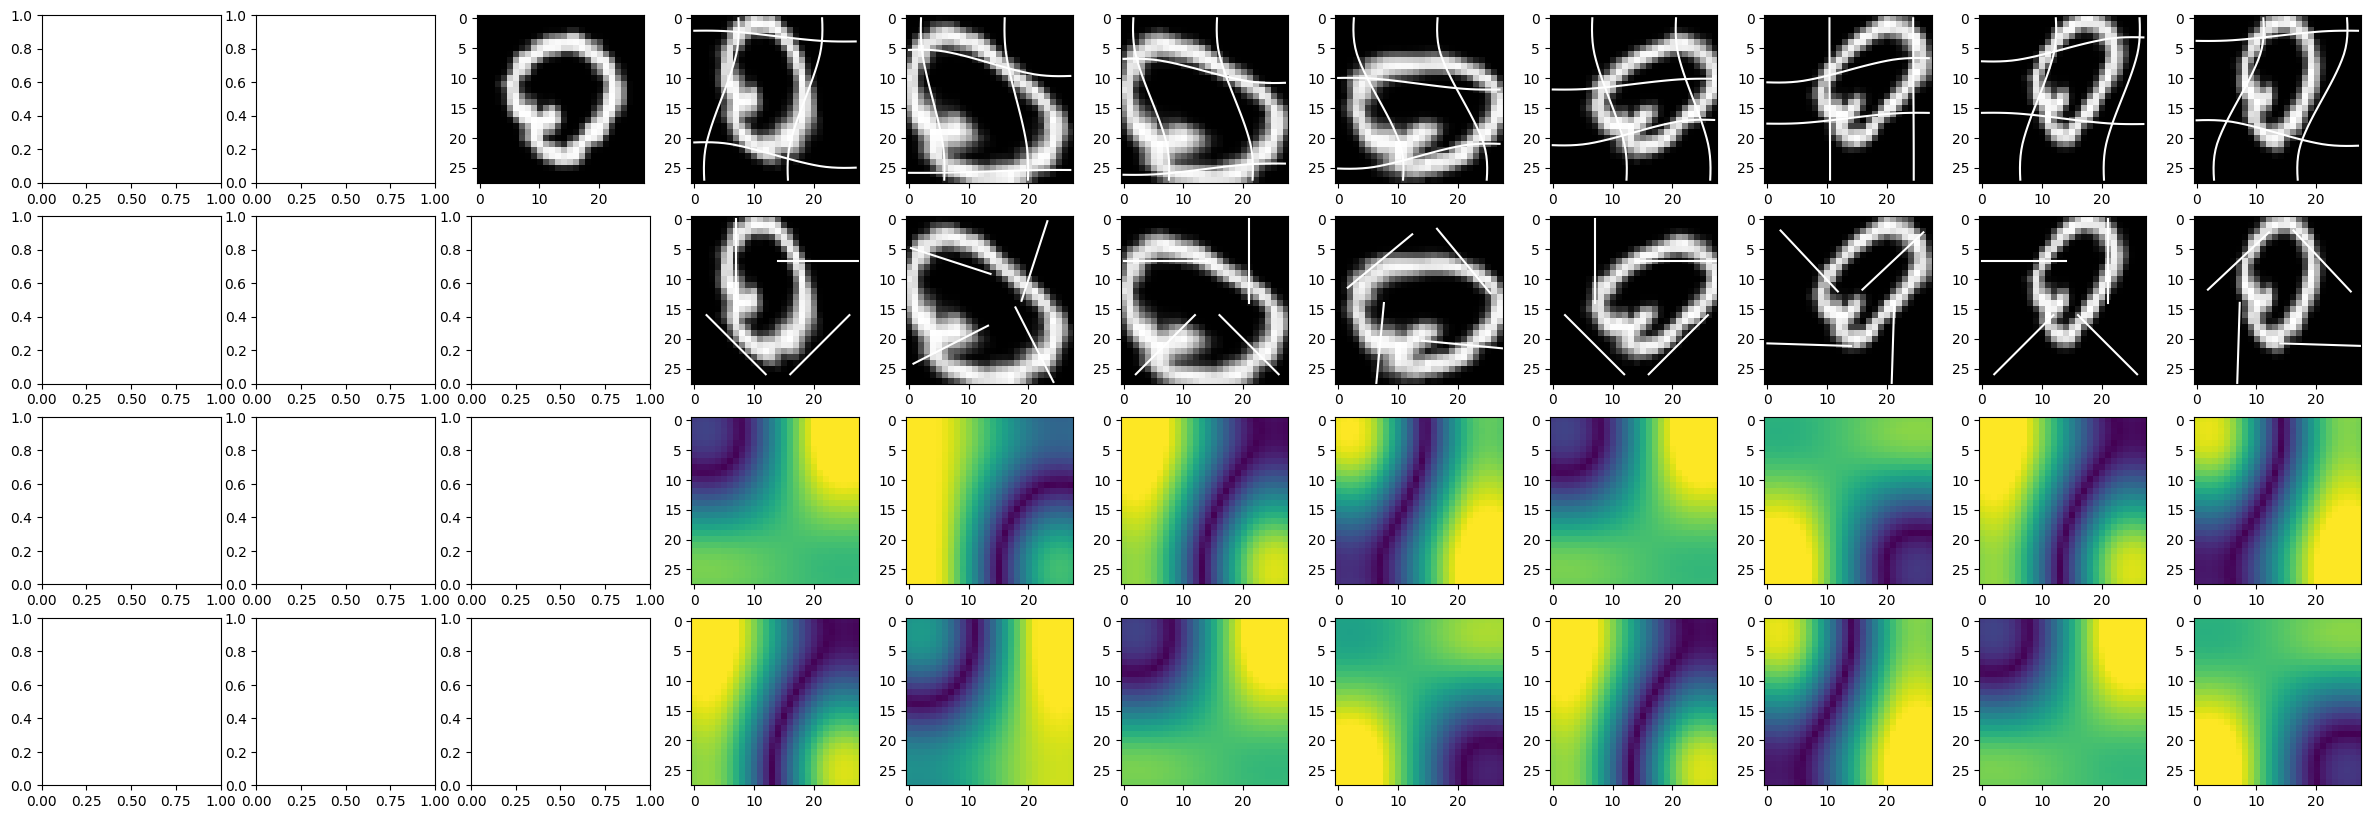

In [236]:
out_pic = tensor_pic
# mask = out_pic == out_pic.min()
# out_pic[mask] = out_pic.max()

pic_size = (28,28)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
deform_grid_shape = (2,2)

intensity_tolerance = 500
line, axs = plt.subplots(4,11, figsize=(30,10))
# axs[0, 0].imshow(color_and_normalize(out_pic, 50, 300, intensity_tolerance))
# axs[0, 1].imshow(color_and_normalize(out_pic, 0, 120, intensity_tolerance))
# axs[2].imshow(color_and_normalize(out_pic, 180, 270, intensity_tolerance))
axs[0, 2].imshow(out_pic.permute((1,2,0)).numpy(), cmap="gray")
axs[0, 3].imshow(cyclic_deform(out_pic, 0, 100, deform_grid_shape, pic_size, axs, 3), cmap="gray")
axs[0, 4].imshow(cyclic_deform(out_pic, 20, 100, deform_grid_shape, pic_size, axs, 4), cmap="gray")
axs[0, 5].imshow(cyclic_deform(out_pic, 25, 100, deform_grid_shape, pic_size, axs, 5), cmap="gray")
axs[0, 6].imshow(cyclic_deform(out_pic, 36, 100, deform_grid_shape, pic_size, axs, 6), cmap="gray")
axs[0, 7].imshow(cyclic_deform(out_pic, 50, 100, deform_grid_shape, pic_size, axs, 7), cmap="gray")
axs[0, 8].imshow(cyclic_deform(out_pic, 62, 100, deform_grid_shape, pic_size, axs, 8), cmap="gray")
axs[0, 9].imshow(cyclic_deform(out_pic, 75, 100, deform_grid_shape, pic_size, axs, 9), cmap="gray")
axs[0, 10].imshow(cyclic_deform(out_pic, 87, 100, deform_grid_shape, pic_size, axs, 10), cmap="gray")